# Combined Crime and Census Data for Portland, OR.

### This notebook contains data wrangling, storytelling, and statistical analysis related to combined data from the 2015 Crime Statistics from the city of Portland OR and 2010 Census data.

### The main question considered are what key features of a neighborhood related to crime rate and if racial diversity of a neighborhood plays a significant role in predicting crime rate or if it is merely a consequence of other socio-economic factors within a neighborhoods population.

# 0. Imports and Data Reading

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Get data
dfcrime=pd.read_csv('./CrimeData/Crime.csv')
dfcensus=pd.read_csv('./CrimeData/2010CensusPDX.csv')

def Ttest(x,y):
    """Two Sample t-test of mean for samples of varying size"""
    x_n=len(x)
    y_n=len(y)
    x_bar=np.mean(x)
    y_bar=np.mean(y)
    x_s=np.std(x)
    y_s=np.std(y)
    T=np.abs(x_bar-y_bar)/np.sqrt((x_s**2)/x_n+(y_s**2)/y_n)
    p=1-stats.t.cdf(T,x_n+y_n-2)
    return(p,x_bar,y_bar)

# 1. Data Wrangling

## 1.1. Crime Stats Cleaning

### The crime data must be restricted to crime reported in 2015. Many columns irrelevent to the interest of this analysis will be removed. Also, removed are any crime reports which have no location identification. The remaining crime reports will be assigned a neighborhood based on the longitude and latitude of the crime. Crime reports with neighborhood identification but no latitude and longitude will be assigned lattitude and longitude equal to the centroid of the reported locations from that neighborhood.

In [2]:
#Slice only 2015 crime data
df_crime_2015=dfcrime.loc[dfcrime['Occur Date'].str.endswith('/15')]
df_crime_2015.head()

#Remove columns not needed
df_crime_2015.columns
drop_list=['Address','Case Number', 'Number of Records', 'Occur Month Year', 'Open Data X',
           'Open Data Y','Report Month Year','Offense Type', 'Report Date']
df_crime=df_crime_2015.drop(drop_list, axis=1)
df_crime=df_crime.reset_index(drop=True)

# Reorder columns putting identifiers first and crime info last
columns=['Neighborhood', 'Occur Date',
         'Open Data Lat', 'Open Data Lon', 'Crime Against', 'Offense Category', 'Offense Count']
df_crime=df_crime[columns]

# Remove Rows where Neighborhood, Open Data Lat, and Open Data Lon are not not known. There
    # are other rows with Lat/Lon with no Neighborhood. Perhaps Neighborhood can be interpreted
    # from Lat and Lon.
    
# Remove rows missing all location identifiers
df_crime_location=df_crime.loc[pd.notnull(df_crime['Neighborhood']) |
                                  pd.notnull(df_crime['Open Data Lon']) |
                                  pd.notnull(df_crime['Open Data Lat'])]
#Reindex
df_crime_location.index=range(len(df_crime_location.index))

# Fill in rows with missing lon,lat with neighborhood center.
df_crime_neighborhood_centers=df_crime_location.groupby(['Neighborhood'])['Open Data Lon','Open Data Lat'].mean()
for idx, row in df_crime_location.iterrows():
    if str(row['Neighborhood'])!='nan'and str(row['Open Data Lon'])==str(row['Open Data Lat']):
        neigh=row['Neighborhood']
        df_crime_location['Open Data Lon'].values[idx]=df_crime_neighborhood_centers['Open Data Lon'][neigh]
        df_crime_location['Open Data Lat'].values[idx]=df_crime_neighborhood_centers['Open Data Lat'][neigh]
        
# Fill in missing Neighborhoods by lon,lat to closest center.
for idx, row in df_crime_location.iterrows():
    if str(row['Neighborhood'])=='nan':
        lon1=row['Open Data Lon']
        lat1=row['Open Data Lat']
        min_dist=1000.0
        for idx2, row2 in df_crime_neighborhood_centers.iterrows():
            lon2=row2['Open Data Lon']
            lat2=row2['Open Data Lat']
            if min_dist==1000.0:
                min_dist=np.linalg.norm([[lon1,lat1],[lon2,lat2]])
                idx3=idx2
            else:
                dist=np.linalg.norm([[lon1,lat1],[lon2,lat2]])
                if dist<min_dist:
                    min_dist=dist
                    idx3=idx2
        df_crime_location['Neighborhood'].values[idx]=idx3 

#Capitalize Neighborhoods and Combine Buckman East and West to match demographic Neighborhoods
for idx, row in df_crime_location.iterrows():
    if row['Neighborhood']=='Buckman East' or row['Neighborhood']=='Buckman West':
        row['Neighborhood']='Buckman'
    df_crime_location['Neighborhood'].values[idx]=row['Neighborhood'].upper()
    
#Reindex
df_crime_location.index=range(len(df_crime_location.index))

# Aggregate crime by Neighborhood
df_crime_neigh_agg=pd.DataFrame(df_crime_location.groupby(['Neighborhood'])['Offense Count'].sum())

# print(df_crime_location.head())
df_crime_neigh_agg.head()

,Offense Count
Neighborhood,
ALAMEDA,104
ARBOR LODGE,328
ARDENWALD,20
ARGAY,398
ARLINGTON HEIGHTS,66


## 1.2. Demographic Summary
### The 'Total' column is population total per Neighborhood. It is tied to columns which break down population by race. A larger number of columns are dedicated to groupings by sex and age rages. There are also aggregate columns for minors(<18) and elderly(>=65). There is a total household count and these are broken down into a number of household types based on family or non-family structure and owner or renter occupied. Included is a breakdown of vacant households of various types as well as total neighborhood area and total neighborhood water area.

In [3]:
dfcensus.head()

,Neighborhood,Total,White,African American,Native American,Asian,Pacific Islander,Other Race,Multi-Racial,Hispanic,...,Rental Vacancies,For Sale Vacancies,Rented or Sold but unoccupied,Seasonal use units,Units for Migrant workers,Other vacant,Population in owner occupied housing units,Population in renter occupied housing units,"Land area in square meters (divide by 2,589,988 to derive square miles)","Water area in square meters (divide by 2,589,988 to derive square miles)"
0,ALAMEDA,5214,4617,112,9,125,10,15,152,174,...,7,18,2,4,0,17,4725,488,1590610,0
1,ARBOR LODGE,6153,4702,299,44,306,67,33,278,424,...,26,22,11,11,0,40,4295,1850,2252448,0
2,ARDENWALD-JOHNSON CREEK,4748,4105,87,35,83,10,9,148,271,...,28,16,8,8,0,43,3023,1693,2998136,20882
3,ARGAY,6006,3201,751,57,616,109,15,221,1036,...,109,16,11,5,0,21,3278,2665,4921570,214516
4,ARLINGTON HEIGHTS,718,628,7,1,31,0,1,27,23,...,1,6,3,6,0,12,679,39,2329338,14939


## 1.3. Demographics Cleaning
### The Excel spreadsheet had many formatting issues and long column names which were easier to fix prior to conversion. Also, non-needed rows and columns were removed and some aggregate columns were created or renamed for clarification. Also, all columns and Neighborhoods were converted to text and all other data to integer values. 

### The final steps below showed a natural pairing of Neighborhood Names between the crime aggregate and census data. However, some names came with some variation so these are redefined to be the same in both dataframes.

In [4]:
# #Comparing Neighborhood Names in Crime and Demographics
# for idx, row in dfcensus.iterrows():
#     print(df_crime_neigh_agg.index[idx], dfcensus['Neighborhood'][idx])
    
# Unify Neighborhood Names for crime aggregate and census
for idx, row in dfcensus.iterrows():
    dfcensus['Neighborhood'].values[idx]=df_crime_neigh_agg.index[idx]

# #Confirming 
# for idx, row in dfcensus.iterrows():
#     print(df_crime_neigh_agg.index[idx], dfcensus['Neighborhood'][idx])

## 1.4. Creating Neighborhood Diversity Proportions

### Race: White, African American, Hispanic, Asian, Other
### Age: Minors, Senior
### Sex: Male
### Households: Pop in Owner Occupied, Rental Unit Prop
### Family Housing Units: Lone Male, Lone Female, Couples No Kids, Male w/ Kids, Female w/ Kids, Couple w/ Kids

In [5]:
# Adding Crime Totals
dfcensus['Crimes']=df_crime_neigh_agg.values

#Adding Crime Rates per capita
dfcensus['Crime Rate']=np.divide(dfcensus['Crimes'],dfcensus['Total'])

# Adding Race Proportions
dfcensus['White Prop']=np.divide(dfcensus['White'],dfcensus['Total'])
dfcensus['Affrican Am Prop']=np.divide(dfcensus['African American'],dfcensus['Total'])
dfcensus['Hispanic Prop']=np.divide(dfcensus['Hispanic'],dfcensus['Total'])
dfcensus['Asian Prop']=np.divide(dfcensus['Asian'],dfcensus['Total'])
dfcensus['Other Race Prop']=np.divide(dfcensus['Native American']+dfcensus['Pacific Islander']+dfcensus['Other Race']+dfcensus['Multi-Racial'],dfcensus['Total'])

#Adding Age and Sex Proportions
dfcensus['Male Prop']=dfcensus['Total']
dfcensus['Minor Prop']=dfcensus['Total']
dfcensus['Senior Prop']=dfcensus['Total']
for idx, row in dfcensus.iterrows():
    dfcensus['Male Prop'].values[idx]=np.sum(row[10:29])
    dfcensus['Minor Prop'].values[idx]=np.sum(row[10:14])+np.sum(row[30:34])
    dfcensus['Senior Prop'].values[idx]=np.sum(row[25:31])+np.sum(row[45:51])

dfcensus['Male Prop']=np.divide(dfcensus['Male Prop'],dfcensus['Total'])
dfcensus['Minor Prop']=np.divide(dfcensus['Minor Prop'],dfcensus['Total'])
dfcensus['Senior Prop']=np.divide(dfcensus['Senior Prop'],dfcensus['Total'])

#Adding Household proportions
dfcensus['Pop in Owner Occupied Prop']=np.divide(dfcensus['Population in owner occupied housing units'],dfcensus['Total'])
dfcensus['Rental Unit Prop']=np.divide(dfcensus['Renter occupied'],dfcensus['Total Households'])
dfcensus['Vacant For Sale Prop']=np.divide(dfcensus['For Sale Vacancies'],dfcensus['Total Households'])

# Adding Family proportions
dfcensus['Lone Male Prop']=np.divide(dfcensus['Lone Male Household'],dfcensus['Total Households'])
dfcensus['Lone Female Prop']=np.divide(dfcensus['Lone Female Household'],dfcensus['Total Households'])
dfcensus['Couples No Children Prop']=np.divide(dfcensus['Couple Household'],dfcensus['Total Households'])
dfcensus['Male with Children Prop']=np.divide(dfcensus['Single Male Householder with children'],dfcensus['Total Households'])
dfcensus['Female with Children Prop']=np.divide(dfcensus['Single Female Householder with children'],dfcensus['Total Households'])
dfcensus['Couples with Children Prop']=np.divide(dfcensus['Couple with Children Household'],dfcensus['Total Households'])

# Slice to get all proportions and crime rate per neighborhood 
cols=['Neighborhood']+list(dfcensus.columns[-18:])
df_crime_census=dfcensus.loc[:,cols]
df_crime_census.columns

print(df_crime_census.columns)
df_crime_census.head()

Index(['Neighborhood', 'Crime Rate', 'White Prop', 'Affrican Am Prop',
       'Hispanic Prop', 'Asian Prop', 'Other Race Prop', 'Male Prop',
       'Minor Prop', 'Senior Prop', 'Pop in Owner Occupied Prop',
       'Rental Unit Prop', 'Vacant For Sale Prop', 'Lone Male Prop',
       'Lone Female Prop', 'Couples No Children Prop',
       'Male with Children Prop', 'Female with Children Prop',
       'Couples with Children Prop'],
      dtype='object')


,Neighborhood,Crime Rate,White Prop,Affrican Am Prop,Hispanic Prop,Asian Prop,Other Race Prop,Male Prop,Minor Prop,Senior Prop,Pop in Owner Occupied Prop,Rental Unit Prop,Vacant For Sale Prop,Lone Male Prop,Lone Female Prop,Couples No Children Prop,Male with Children Prop,Female with Children Prop,Couples with Children Prop
0,ALAMEDA,0.019946,0.885501,0.021481,0.033372,0.023974,0.035673,0.483506,0.223245,0.429804,0.906214,0.094752,0.008746,0.054908,0.118076,0.621477,0.012148,0.039845,0.309038
1,ARBOR LODGE,0.053307,0.764180,0.048594,0.068909,0.049732,0.068584,0.499919,0.145295,0.394929,0.698033,0.297404,0.007931,0.138068,0.142394,0.375631,0.018745,0.050469,0.135905
2,ARDENWALD,0.004212,0.864575,0.018324,0.057077,0.017481,0.042544,0.483151,0.191660,0.424810,0.636689,0.384797,0.007554,0.126534,0.163834,0.388102,0.029745,0.067517,0.162890
3,ARGAY,0.066267,0.532967,0.125042,0.172494,0.102564,0.066933,0.487013,0.215285,0.449051,0.545788,0.406325,0.006405,0.099279,0.160128,0.416733,0.022418,0.079664,0.146117
4,ARLINGTON HEIGHTS,0.091922,0.874652,0.009749,0.032033,0.043175,0.040390,0.502786,0.193593,0.480501,0.945682,0.048860,0.019544,0.074919,0.061889,0.644951,0.009772,0.019544,0.254072


# 2. Data Storytelling

## 2.1. What kinds of diversity are related to crime?

### This motivating question is behind the organization of the 2015 crime with 2010 Census data seen above. The given proportions can be used to define a number of diversity measures per neighborhood which can be explored in connection with crime rates. The diversity proportions being examined are related to race, economic household types, and living arrangements. 

### Initial EDA will be used to identify clear outliers which should be eliminated and then to identify potential relationships between each factor and crime as well as relationships among the factors. These will motivate the statistical hypothesis testing in Section 3 to identify the statistically significant and independent factors related to crime. 

## 2.2 Removal of Extreme Outliers

### We start by looking for extremal outliers for crime rate and non-race proportions as Portland is heavily white and eliminating outliers based on proportions of small sub-populations is not appropriate.

### Northwest Industrial: Like many cities, the industrial district has abnormally high crime for many reasons. We remove this neighborhood as it is extreme and non-residential.

### Sunderland and Old Town China Town: These neighborhoods have extremely high male proportions relative to the norm.

### Lloyd: This is not a residential area but is home to much night-life activity including sporting events and large crowds. Its high crime rate is easily explained by this.

In [6]:
Xtreme_outs=[]
outliers=[]
cols=list(df_crime_census.columns[-12:])
cols.append('Crime Rate')
cols.append('White Prop')
for idx, row in df_crime_census.iterrows():
    for col in cols:
        if col!='Neighborhood':
            X=df_crime_census[col]
            avg=np.mean(X)
            stdev=np.std(X)
            if row[col]>=avg+6*stdev or row[col]<=avg-6*stdev:
                if idx not in outliers:
                    outliers.append(idx)
                if (col,idx) not in Xtreme_outs:
                    Xtreme_outs.append((col,idx))
                    print(idx,row['Neighborhood'],col+'=',row[col])
print('Extreme Outliers:',outliers)
df_out1=df_crime_census.drop(outliers,inplace=False)

for idx, row in df_out1.iterrows():
    for col in cols:
        if col!='Neighborhood':
            X=df_out1[col]
            avg=np.mean(X)
            stdev=np.std(X)
            if row[col]<= avg-6*stdev or row[col]>=avg+6*stdev:
                if idx not in outliers:
                    outliers.append(idx)
                if (col,idx) not in Xtreme_outs:
                    Xtreme_outs.append((col,idx))
                    print(idx,row['Neighborhood'],col+'=',row[col])
print('All Outliers:',outliers)

61 NORTHWEST INDUSTRIAL Crime Rate= 8.0
85 SUNDERLAND Male Prop= 0.9122562674094707
Extreme Outliers: [61, 85]
48 LLOYD Crime Rate= 0.8274956217162872
62 OLD TOWN/CHINATOWN Male Prop= 0.7151963284038756
All Outliers: [61, 85, 48, 62]


In [7]:
df_crime_census_out=df_crime_census.drop(outliers,inplace=False)
df_crime_census_out.head()

,Neighborhood,Crime Rate,White Prop,Affrican Am Prop,Hispanic Prop,Asian Prop,Other Race Prop,Male Prop,Minor Prop,Senior Prop,Pop in Owner Occupied Prop,Rental Unit Prop,Vacant For Sale Prop,Lone Male Prop,Lone Female Prop,Couples No Children Prop,Male with Children Prop,Female with Children Prop,Couples with Children Prop
0,ALAMEDA,0.019946,0.885501,0.021481,0.033372,0.023974,0.035673,0.483506,0.223245,0.429804,0.906214,0.094752,0.008746,0.054908,0.118076,0.621477,0.012148,0.039845,0.309038
1,ARBOR LODGE,0.053307,0.764180,0.048594,0.068909,0.049732,0.068584,0.499919,0.145295,0.394929,0.698033,0.297404,0.007931,0.138068,0.142394,0.375631,0.018745,0.050469,0.135905
2,ARDENWALD,0.004212,0.864575,0.018324,0.057077,0.017481,0.042544,0.483151,0.191660,0.424810,0.636689,0.384797,0.007554,0.126534,0.163834,0.388102,0.029745,0.067517,0.162890
3,ARGAY,0.066267,0.532967,0.125042,0.172494,0.102564,0.066933,0.487013,0.215285,0.449051,0.545788,0.406325,0.006405,0.099279,0.160128,0.416733,0.022418,0.079664,0.146117
4,ARLINGTON HEIGHTS,0.091922,0.874652,0.009749,0.032033,0.043175,0.040390,0.502786,0.193593,0.480501,0.945682,0.048860,0.019544,0.074919,0.061889,0.644951,0.009772,0.019544,0.254072


## 2.2 Identifying Potentially Key Diversity Measures through EDA

In [8]:
# Dividing Features by Group: Race, Sex/Age, Economic, Family
cols=df_crime_census_out.columns

cols_race=[x for x in cols if x=='White Prop']
cols_race.append('Crime Rate')

cols_pop=[x for x in cols[7:10] if x !='Senior Prop']
cols_pop.append('Crime Rate')

cols_econ=[x for x in cols[10:13] if x != 'Vacant For Sale Prop']
cols_econ.append('Crime Rate')

cols_family=[x for x in cols[13:] if x!='Male with Children Prop' and x!='Female with Children Prop']
cols_family.append('Crime Rate')

### Race: There are no neighborhoods with less than a 44% white population and EDA shows little potential for relationships between different racial proportions. Below is the most visually indicative relationship between race and crime, i.e. 'White Prop' vs 'Crime Rate'. However, this relationship does not appear that strong on the surface. However, it may reveal stronger relationships when combined with other features.

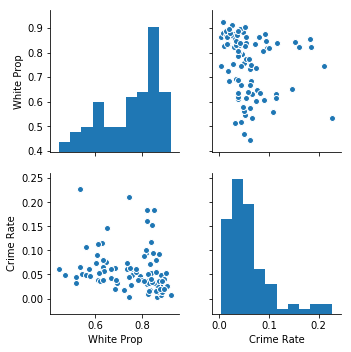

In [9]:
sns.pairplot(df_crime_census_out,vars=cols_race)
plt.show()

### Sex/Age: There appears to be some relationship between an imbalance in the sex of a neighborhood and the proportion of children in a neighborhood. However, the proportion of senior citezens and crime did not appear to have any significant relationship.

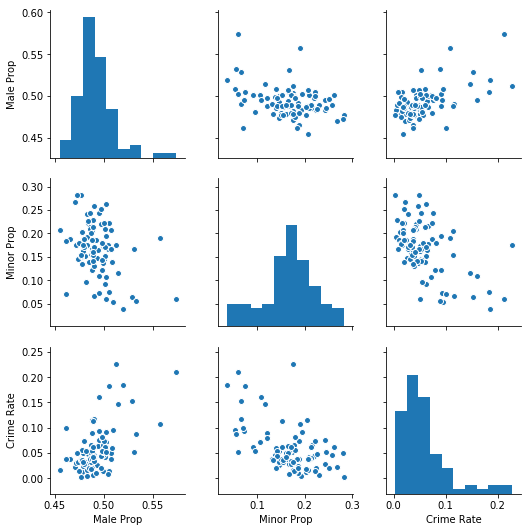

In [10]:
sns.pairplot(df_crime_census_out,vars=cols_pop)
plt.show()

### Economic: The proportion of a neighborhoods population living in owner occupied homes and the proportion of rental units in a neighborhood appear to be strongly negatively correlated. In general, this is not necessarily to be expected, at least not with such a high appearing correlation. As such, both factors seem to be related to crime rate.

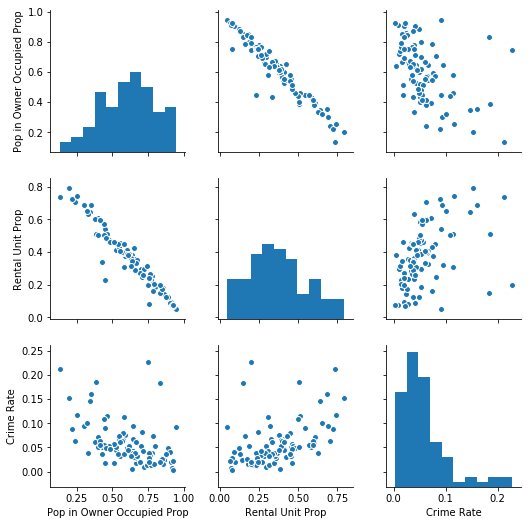

In [11]:
sns.pairplot(df_crime_census_out,vars=cols_econ)
plt.show()

### Family: The proportions of single parent households appeared to have little to no relationship wtih crime rate. The more important factors which appear correlated with lower crime rate seem to be proportions of households with couples living together, with or without children. On the other hand, higher proportions of lone residents, male or female, seem to have a positive correlation with crime rate. 

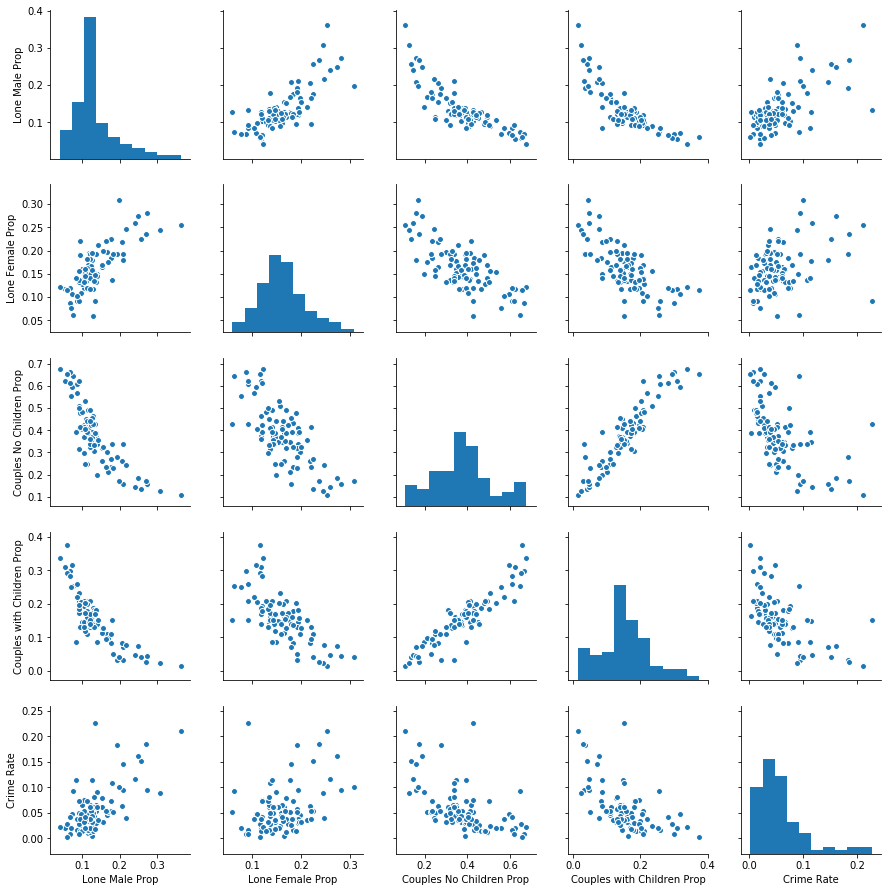

In [12]:
sns.pairplot(df_crime_census_out,vars=cols_family)
plt.show()

## 2.3 'Predominantly White' vs 'More Diverse Neighborhoods'

### The bi-modal histogram below suggests two distinct populations with the Portland neighborhoods, Those with a 'White Prop' of 74% or higher and those which have a 'White Prop' ranging from 45% to 73%. We will be interested to see if this variable is connected to crime rate in a statistically significant manner and if other variables have different connections to crime rate in Portland neighborhoods relative to this boolean distinction between 'Predominantly White' neighborhoods and the 'More Diverse Neighborhoods'.

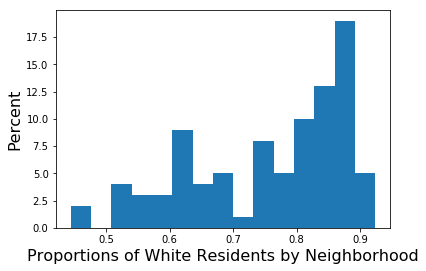

In [13]:
# White Prop
plt.hist(df_crime_census_out['White Prop'],bins=15)
plt.xlabel('Proportions of White Residents by Neighborhood', fontsize=16)
plt.ylabel('Percent',fontsize=16)
plt.show()

### Below are the crime rate distributions of these two populations. 

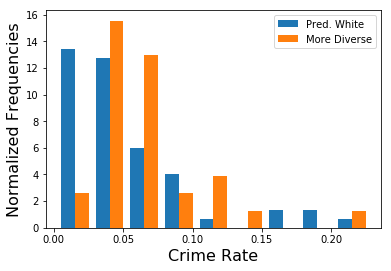

In [14]:
df_crime_census_out['Predominantly White']=df_crime_census_out['White Prop']>=0.73
df_white=df_crime_census_out.loc[df_crime_census_out['Predominantly White']==True]
df_diverse=df_crime_census_out.loc[df_crime_census_out['Predominantly White']==False]
plt.xlabel('Crime Rate', fontsize=16)
plt.ylabel('Normalized Frequencies',fontsize=16)
plt.hist([df_white['Crime Rate'],df_diverse['Crime Rate']],bins=9, density=True)
plt.legend(['Pred. White','More Diverse'])
plt.show()

### The above graphic suggests a relationship between crime rate and the 'Predominantly White' variable created above. However, the only visual difference is on the extremely lower end of the crime rate spectrum. There appears to equally many neighborhoods of each type with crime rates on the higher end. It will be interesting to see how crime rate is related to our other key features when combined with this splitting of the population as above.

## 2.4 Story Telling Summary

### In the next section we will test a variety of hypotheses to see which key features actually have statistically significant relationships with crime rate.

### A second round of hypotheses test will be used to see if the population mean values of the key features are statistically different with respect to the more 'Predominantly White' neighborhoods. If so, this data would suggest that any relationship between race and crime rate is a consequence of other cultural and economic factors or vice-versa.

### For example, if the key features with strong positive/negative correlation with crime rate have higher/lower means with respect to higher/lower proportion of white residents, then any relation to race and crime may be a consequence of other socio-economic choices like 'living with close friends and family' instead of 'alone'. There are economic opportunities that have been lost for certain groups for a number of reasons. However, we need to identify which of these reasons are caused by the system and which by the individuals choices. A systemic cause is likely the lack of affordable homes for sale. However, if one chooses to live alone in a community of others living alone then it is more difficult to save money and eventually put oneself in a position of higher economic security. 

# 3. Statistical Testing

## 3.1 Do 'Predominantly White' neigborhoods have higher crime rates on avgerage?

$H_o:\mu_{PW}=\mu_{MD}$

$H_a:\mu_{PW}<\mu_{MD}$

### The p-value of this test is 0.08. This suggests, with 10% significance, that the 5.3 crimes per 100 residents in 2015 for 'Predominantly White' neighborhoods is statistically smaller than the 6.6 crimes per 100 residents in 2015 for 'More Diverse' nieghborhoods. However, at 5% significance this data does not provide sufficient evidence to reject the assumption that the crime rates for these populations are equal. Since choosing any statistical significance is somewhat arbitrary, these observations provide little practical difference on their own. 

In [15]:
more_white=[row['Crime Rate'] for idx, row in df_crime_census_out.iterrows() if row['Predominantly White']==True]
less_white=[row['Crime Rate'] for idx, row in df_crime_census_out.iterrows() if row['Predominantly White']==False]
p, w_bar, d_bar=Ttest(more_white,less_white)
p, w_bar, d_bar

(0.08093738631559122, 0.053109635475300156, 0.06646051752740174)

## 3.1 Pearson's Test For Correlation

### For each of the features X, which our visual EDA suggested had correlation with crime rate, we run the following hypothesis test.

$H_o:\text{Crime Rate and X are not correlated}$

$H_a:\text{Crime Rate and X are correlated}$

### In every case, the small p-value suggests the existence of correlation while the sign of the correlation coefficient indicates positive or negative correlation. However, the correlation coefficients are genearlly not close to 1 in absolute value so either this correlation is not particularly strong or perhaps the correlation is non-linear. However, these correlations do confirm the visual appearance that these features are the most important from the data in terms of relating to crime rate.

In [16]:
features=[]
groups=[cols_pop,cols_econ,cols_family]
for group in groups:
    for col in group:
        if col!='Crime Rate' and col not in features:
            features.append(col)
L=len(features)
features

['Male Prop',
 'Minor Prop',
 'Pop in Owner Occupied Prop',
 'Rental Unit Prop',
 'Lone Male Prop',
 'Lone Female Prop',
 'Couples No Children Prop',
 'Couples with Children Prop']

In [17]:
pos_features=[]
neg_features=[]
for j in features:
    corr, p = stats.pearsonr(np.array(df_crime_census_out[j]),np.array(df_crime_census_out['Crime Rate']))
    print(j+' and Crime Rate:'+' R ='+str(corr)+' p ='+str(p))
    if p<0.025:
        if corr<0:
            neg_features.append(j)
        else:
            pos_features.append(j)
print('\nPositively Correlated with Crime Rate')
print(pos_features)
print('Negatively Correlated with Crime Rate')
print(neg_features)   

Male Prop and Crime Rate: R =0.5557671334326453 p =1.0745813463748223e-08
Minor Prop and Crime Rate: R =-0.5191031595018131 p =1.350845012058783e-07
Pop in Owner Occupied Prop and Crime Rate: R =-0.48146149219091644 p =1.3562254343765438e-06
Rental Unit Prop and Crime Rate: R =0.45144452891318226 p =7.077013382123543e-06
Lone Male Prop and Crime Rate: R =0.6560059198747704 p =1.6895917704543447e-12
Lone Female Prop and Crime Rate: R =0.35770106393766865 p =0.0004995395735238612
Couples No Children Prop and Crime Rate: R =-0.5627101281685083 p =6.424025704932682e-09
Couples with Children Prop and Crime Rate: R =-0.5985716146933148 p =3.692965201528025e-10

Positively Correlated with Crime Rate
['Male Prop', 'Rental Unit Prop', 'Lone Male Prop', 'Lone Female Prop']
Negatively Correlated with Crime Rate
['Minor Prop', 'Pop in Owner Occupied Prop', 'Couples No Children Prop', 'Couples with Children Prop']


## 3.2 Feature Comparison: 'Predominantly White' vs 'More Diverse'

### For each feature X, we compare the means for 'PW' vs 'MD' to if there is a difference.

$H_o:\mu_{X,PW}=\mu_{X,MD}$

$H_a:\mu_{X,PW}\neq\mu_{X,MD}$

### For features with positive correlation to crime rate, 'PW' neighborhoods appear to have statistically higher mean values for 'Lone Male Prop' and 'Lone Female Prop'. Thus, these features should tend to explain higher crime rates in 'PW' neighborhoods with larger proportions of households with single occupants. 

### For features with negative correlation to crime rate, 'PW' neighborhoods appear to have a statistically higher mean value for 'Pop in Owner Occupied Homes' while 'MD' neighborhoods appear to have a statistically higher mean value for 'Minor Prop'. Thus, lower crime rates in 'PW' neighborhoods may be caused by more economically stable homes while larger proportions of minors living in 'MD' neighborhoods can have different effects. Larger proportions of minors tends to correlate with lower crime rate. This can be explained by the fact that most crimes are committed by adults. On the other hand, more children means more econimic pressures on families.


In [18]:
print('Positive Correlations with Crime Rate')
for j in pos_features:
    w=[x[j] for idx, x in df_crime_census_out.iterrows() if x['Predominantly White']==True]
    d=[x[j] for idx, x in df_crime_census_out.iterrows() if x['Predominantly White']==False]
    p, w_bar, d_bar=Ttest(w,d)
    print(j+': P-value ='+str(round(p,3))+', PW Mean = '+str(round(w_bar,3))+', MD Mean = '+str(round(d_bar,3)))
print('Negative Correlations with Crime')       
for j in neg_features:
    w=[x[j] for idx, x in df_crime_census_out.iterrows() if x['Predominantly White']==True]
    d=[x[j] for idx, x in df_crime_census_out.iterrows() if x['Predominantly White']==False]
    p, w_bar, d_bar=Ttest(w,d)
    print(j+': P-value ='+str(round(p,3))+', PW Mean = '+str(round(w_bar,3))+', MD Mean = '+str(round(d_bar,3)))   

Positive Correlations with Crime Rate
Male Prop: P-value =0.494, PW Mean = 0.493, MD Mean = 0.493
Rental Unit Prop: P-value =0.021, PW Mean = 0.346, MD Mean = 0.414
Lone Male Prop: P-value =0.02, PW Mean = 0.142, MD Mean = 0.121
Lone Female Prop: P-value =0.004, PW Mean = 0.169, MD Mean = 0.146
Negative Correlations with Crime
Minor Prop: P-value =0.0, PW Mean = 0.154, MD Mean = 0.194
Pop in Owner Occupied Prop: P-value =0.004, PW Mean = 0.639, MD Mean = 0.549
Couples No Children Prop: P-value =0.021, PW Mean = 0.396, MD Mean = 0.346
Couples with Children Prop: P-value =0.229, PW Mean = 0.158, MD Mean = 0.148


## 3.3 Expected Lower Crime(ECL) Neighborhoods

### Next we consider neighborhoods for which the key features predict lower crime, i.e. those neighborhoods with a higher than 80th percentile in features negatively correlated with crime rate and a lower than 20th percentile in features positively correlated to crime. 

### Over one third of neighborhoods fall into this category and the correlations of the key features suggest these neighborhoods have a lower crime rate than a typical neighborhood.  Is crime rate statistically lower in such neighborhoods? Does racial diversity imply a different crime rate in such neighborhoods?

### Of these neighborhoods there are 20 which are 'PW' and 17 which are 'MD'. Thus, although 66% of neighborhoods are 'PW', 54% of these neighborhoods are 'PW'.

### With a p-value of 0.0001, these neighborhoods have a lower average crime rate of 3.9 crimes per 100 residents in 2015 compared to the 5.8 crimes per 100 residents for all neighborhoods in 2015.

### With a p-value of 0.0001, the 'PW' of these feature-predicted lower crime neighborhoods have a lower average crime rate of 2.8 crimes per 100 residents in 2015 compared to 5.2 crimes per 100 residents in the 'MD'. 

In [19]:
# Median values of features where PW and MD have statistically different means.
cut1=np.percentile(df_crime_census_out['Male Prop'],80)
cut2=np.percentile(df_crime_census_out['Rental Unit Prop'],80)
cut3=np.percentile(df_crime_census_out['Lone Female Prop'],80)
cut4=np.percentile(df_crime_census_out['Lone Male Prop'],80)
cut5=np.percentile(df_crime_census_out['Pop in Owner Occupied Prop'],20)
cut6=np.percentile(df_crime_census_out['Couples No Children Prop'],20)
cut7=np.percentile(df_crime_census_out['Couples with Children Prop'],20)
cut8=np.percentile(df_crime_census_out['Minor Prop'],20)

#Slice the data biased for lower crime rate based on key features.
df_bias_lower_crime=df_crime_census_out.loc[df_crime_census_out['Male Prop']<cut1]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Rental Unit Prop']<cut2]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Lone Female Prop']<cut3]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Lone Female Prop']<cut4]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Pop in Owner Occupied Prop']>cut5]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Couples No Children Prop']>cut6]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Couples with Children Prop']>cut7]
df_bias_lower_crime=df_bias_lower_crime.loc[df_bias_lower_crime['Minor Prop']>cut8]

In [20]:
#Comparing Means of PW and MD for features which favor a lower crime rate for PW
pw_lower_crime=[row['Crime Rate'] for idx, row in df_bias_lower_crime.iterrows() if row['Predominantly White']==True]
md_lower_crime=[row['Crime Rate'] for idx, row in df_bias_lower_crime.iterrows() if row['Predominantly White']==False]
p, w_bar, d_bar=Ttest(pw_lower_crime,md_lower_crime)
print(p, w_bar, d_bar)
len(pw_lower_crime),len(md_lower_crime)

0.00010950659228614601 0.02773625576194517 0.05227357291407971


(20, 17)

In [21]:
# Feature Predicted for lower crime vs all neighborhoods
p, x_bar_bias, x_bar=Ttest(df_bias_lower_crime['Crime Rate'],df_crime_census_out['Crime Rate'])
p, x_bar_bias, x_bar

(0.000997284232224338, 0.03901015823725023, 0.057657738152389726)

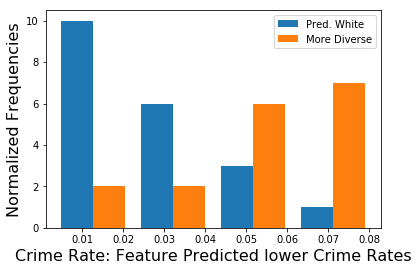

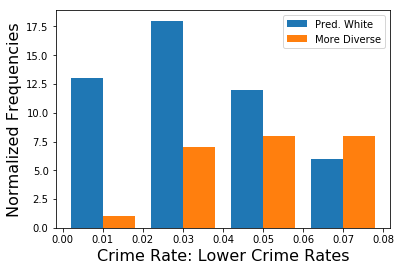

In [22]:
plt.hist([pw_lower_crime,md_lower_crime],bins=4,density=False)
plt.xlabel('Crime Rate: Feature Predicted lower Crime Rates', fontsize=16)
plt.ylabel('Normalized Frequencies',fontsize=16)
plt.legend(['Pred. White','More Diverse'])
plt.show()

plt.hist([df_white['Crime Rate'],df_diverse['Crime Rate']],bins=[0.0,0.02,0.04,0.06,0.08], density=False)
plt.xlabel('Crime Rate: Lower Crime Rates', fontsize=16)
plt.ylabel('Normalized Frequencies',fontsize=16)
plt.legend(['Pred. White','More Diverse'])
plt.show()

# In Conclusion

### With such a large white proportion in Portland, it is difficult to consider any statistically significant connections between crime and race. Even in the case of ECL neighborhoods where it seems that PW neighborhoods have a lower crime rate, it does not seem that race is the main issue. 

### The histogram below illustrates how skewed lower proportions of rental units are skewed towards predominantly white neighborhoods. 

Text(0,0.5,'Frequency')

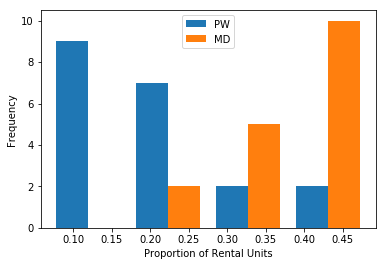

In [25]:
X=[row['Rental Unit Prop'] for idx, row in df_bias_lower_crime.iterrows() if row['Predominantly White']==True]
Y=[row['Rental Unit Prop'] for idx, row in df_bias_lower_crime.iterrows() if row['Predominantly White']==False]

plt.hist([X,Y],bins=4,density=False)
plt.legend(['PW','MD'])
plt.xlabel('Proportion of Rental Units')
plt.ylabel('Frequency')